In [4]:
import requests
from serpapi import GoogleSearch

# Initialize YOLOv5 model
# model = YOLO("yolov8n.pt") 

# params = {
#   "q": "Apple",
#   "engine": "google_images",
#   "ijn": "0",
#   "api_key": "760c4ed9451ad89a9dd73852af588ead8fb0f2051a240481f2d00a38b7d61e15"
# }

# search = GoogleSearch(params)
# results = search.get_dict()
# images_results = results
# print(images_results)

# # Function to download image from URL
# def download_image(url):
# response = requests.get(url)
# image = np.asarray(bytearray(response.content), dtype="uint8")
# image = cv2.imdecode(image, cv2.IMREAD_COLOR)
# return image

# # Function to detect objects in images using YOLO
# def detect_objects(image):
#     results = model.predict(image)
#     return results

# # Main function
# def main(query):
#     images_data = search_images(query)
#     print(images_data)
#     results = []
#     for image_data in images_data:
#         image_url = image_data['contentUrl']
#         image = download_image(image_url)
#         detection = detect_objects(image)
#         results.append({"url": image_url, "objects": detection})
#     return results

# # Example usage
# query = "AirPods"
# results = main(query)
# print(results)


(199, 253, 3)


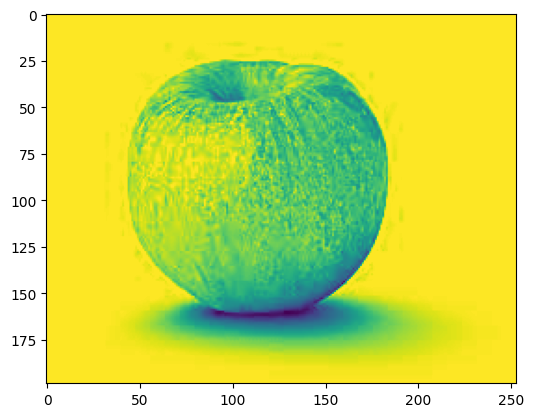

In [31]:
# response = requests.get(images_results["images_results"][1]["thumbnail"])
# image = np.asarray(bytearray(response.content), dtype="uint8")
# image = cv2.imdecode(image, cv2.IMREAD_COLOR)
# print(image.shape)
# plt.imshow(image[:,:,2], cmap="viridis")

In [27]:
import cv2
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.ops import roi_align
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn, FasterRCNN_MobileNet_V3_Large_320_FPN_Weights
from PIL import Image

class FeatureExtractor(torch.nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.model.eval()

    def forward(self, image_tensor):
        with torch.no_grad():
            features = self.model(image_tensor)
        return features

class DetectionModel(torch.nn.Module):
    def __init__(self):
        super(DetectionModel, self).__init__()
        self.model = fasterrcnn_mobilenet_v3_large_320_fpn(weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT)
        self.model.eval()
        self.extractor = FeatureExtractor()
        
    def preprocess_video(self, image):
        transform = transforms.Compose([transforms.ToTensor()])
        image_tensor = transform(image).unsqueeze(0)
        return image_tensor
    
    def crop_regions(self, image_tensor, boxes, output_size=(224, 224)):
        batch_indices = torch.zeros((boxes.size(0), 1), device=boxes.device)
        rois = torch.cat([batch_indices, boxes], dim=1)
        cropped_regions = roi_align(image_tensor, rois, output_size=output_size)
        return cropped_regions

    def process_video(self, video_path, output_path, reference_features):
        cap = cv2.VideoCapture(video_path)
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            input_image_tensor = self.preprocess_video(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))
            with torch.no_grad():
                detection = self.model(input_image_tensor)
                boxes = detection[0]['boxes']
                features = self.extractor(self.crop_regions(input_image_tensor, boxes))
                similarity = F.cosine_similarity(features, reference_features)
                i = similarity.argmax()
                box = boxes[i] if similarity[i] >= 0.7 else None
                if box is not None:
                    box = box.int().tolist()
                    x1, y1, x2, y2 = box
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 5)
            
            out.write(frame)

        cap.release()
        out.release()
        
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image).unsqueeze(0)
    return image, image_tensor

feature_extractor = FeatureExtractor()
reference_image, reference_image_tensor = preprocess_image('bottle.jpg')
with torch.no_grad():
    reference_features = feature_extractor(reference_image_tensor)
detection_model = DetectionModel()
detection_model.process_video(video_path="testvideo.mp4", output_path="output.mp4", reference_features=reference_features)